In [1]:
import pandas as pd 
import requests
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sktime
import imblearn
import seaborn as sns


In [2]:
from io import BytesIO
from sklearn.model_selection import train_test_split  # Importar o train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import spearmanr, kendalltau



In [3]:
# Carregar o arquivo CSV
file_path = "Dados_Históricos_Ibovespa.csv"
dados_brutos= pd.read_csv(file_path, encoding='latin1')

In [4]:

# Para o python ler direto do arquivo na web :
#url = "https://onedrive.live.com/personal/5ce116f2e8d3e8e7/_layouts/15/Doc.aspx?sourcedoc=%7B60903988-24fb-44a9-af58-861cd2be95b6%7D&download=1"

#response = requests.get(url)
#response.raise_for_status()  # Verificar se houve erro no download

#dados_brutos= pd.read_excel(BytesIO(response.content))

#print(dados_brutos.head())

In [5]:
print(dados_brutos)

            Data   Último Abertura   Máxima   Mínima    Vol.    Var%
0     10.01.2025  118,856  119,781  120,052  118,732   9,26M  -0.77%
1     09.01.2025  119,781  119,625  120,145  119,502   6,61M   0.13%
2     08.01.2025  119,625  121,160  121,160  119,351  10,23M  -1.27%
3     07.01.2025  121,163  120,022  121,713  120,022  11,12M   0.95%
4     06.01.2025  120,022  118,534  120,322  118,534   9,69M   1.26%
...          ...      ...      ...      ...      ...     ...     ...
2729  08.01.2014   50,577   50,431   50,793   50,424   2,92M   0.29%
2730  07.01.2014   50,430   50,982   51,478   50,429   3,34M  -1.07%
2731  06.01.2014   50,974   50,980   51,002   50,451   3,73M  -0.01%
2732  03.01.2014   50,981   50,348   50,981   50,269   7,36M   1.27%
2733  02.01.2014   50,341   51,522   51,656   50,246   3,48M  -2.26%

[2734 rows x 7 columns]


In [6]:
# Converter a coluna "Data" para o tipo datetime
dados_brutos['Data'] = pd.to_datetime(dados_brutos['Data'], format='%d.%m.%Y', errors='coerce')

In [7]:
print(dados_brutos.head())


        Data   Último Abertura   Máxima   Mínima    Vol.    Var%
0 2025-01-10  118,856  119,781  120,052  118,732   9,26M  -0.77%
1 2025-01-09  119,781  119,625  120,145  119,502   6,61M   0.13%
2 2025-01-08  119,625  121,160  121,160  119,351  10,23M  -1.27%
3 2025-01-07  121,163  120,022  121,713  120,022  11,12M   0.95%
4 2025-01-06  120,022  118,534  120,322  118,534   9,69M   1.26%


In [8]:
print(dados_brutos['Vol.'].unique())


['9,26M' '6,61M' '10,23M' ... '5,93M' '1,88M' '1,41M']


In [9]:
def transform_vol_to_numeric(volume):
    # Verifica se o valor não é uma string ou está vazio
    if not isinstance(volume, str) or pd.isnull(volume):
        return np.nan

    # Substitui vírgula decimal por ponto
    volume = volume.replace(',', '.')

    # Caso o valor termine com 'K', converte para milhar
    if volume.endswith('K'):
        return float(volume.replace('K', '')) * 1_000

    # Caso o valor termine com 'M', converte para milhão
    elif volume.endswith('M'):
        return float(volume.replace('M', '')) * 1_000_000

    # Caso o valor seja numérico, retorna como float
    try:
        return float(volume)
    except ValueError:
        return np.nan  # Retorna NaN para valores inválidos
vol_tratado2 = dados_brutos['Vol.'].apply(transform_vol_to_numeric)



In [10]:
  #Criei uma nova coluna (Vol_Númerico2) no DataFrame com os valores tratados
dados_brutos['Vol_Numérico2'] = vol_tratado2

# Exibe o DataFrame atualizado
print(dados_brutos.head())

        Data   Último Abertura   Máxima   Mínima    Vol.    Var%  \
0 2025-01-10  118,856  119,781  120,052  118,732   9,26M  -0.77%   
1 2025-01-09  119,781  119,625  120,145  119,502   6,61M   0.13%   
2 2025-01-08  119,625  121,160  121,160  119,351  10,23M  -1.27%   
3 2025-01-07  121,163  120,022  121,713  120,022  11,12M   0.95%   
4 2025-01-06  120,022  118,534  120,322  118,534   9,69M   1.26%   

   Vol_Numérico2  
0      9260000.0  
1      6610000.0  
2     10230000.0  
3     11120000.0  
4      9690000.0  


In [11]:
# Transferindo os valores de 'Vol_Numérico2' para a coluna original 'Vol.'
dados_brutos['Vol.'] = dados_brutos['Vol_Numérico2']

In [12]:
# Removendo a coluna 'Vol_Numérico2'
dados_brutos.drop(columns=['Vol_Numérico2'], inplace=True)

In [13]:
print(dados_brutos.head())

        Data   Último Abertura   Máxima   Mínima        Vol.    Var%
0 2025-01-10  118,856  119,781  120,052  118,732   9260000.0  -0.77%
1 2025-01-09  119,781  119,625  120,145  119,502   6610000.0   0.13%
2 2025-01-08  119,625  121,160  121,160  119,351  10230000.0  -1.27%
3 2025-01-07  121,163  120,022  121,713  120,022  11120000.0   0.95%
4 2025-01-06  120,022  118,534  120,322  118,534   9690000.0   1.26%


In [14]:
# Ordenar os dados pela coluna "Data"
dados_tratados = dados_brutos.sort_values(by='Data',ascending=False)

In [15]:
print(dados_tratados.head())

        Data   Último Abertura   Máxima   Mínima        Vol.    Var%
0 2025-01-10  118,856  119,781  120,052  118,732   9260000.0  -0.77%
1 2025-01-09  119,781  119,625  120,145  119,502   6610000.0   0.13%
2 2025-01-08  119,625  121,160  121,160  119,351  10230000.0  -1.27%
3 2025-01-07  121,163  120,022  121,713  120,022  11120000.0   0.95%
4 2025-01-06  120,022  118,534  120,322  118,534   9690000.0   1.26%


In [16]:
# ETAPA DE TRATAMENTO DO VAR% para strg
dados_brutos['Var%'] = dados_brutos['Var%'].astype(str)




In [17]:
# Removi os espaços em branco
dados_brutos['Var%'] = dados_brutos['Var%'].str.strip()




In [18]:
# Removi o símbolo '%' e substitui vírgulas por pontos
dados_brutos['Var%'] = dados_brutos['Var%'].str.replace('%', '', regex=True).str.replace(',', '.', regex=False)


In [19]:
# Converti os valores para números decimais
# Inclui tratamento de erro para valores não numéricos
dados_brutos['Var%'] = pd.to_numeric(dados_brutos['Var%'], errors='coerce') / 100


In [20]:
# Ajustando para 4 casas decimais
dados_brutos['Var%'] = dados_brutos['Var%'].round(4)




In [21]:
# Garantir que todas as colunas numéricas sejam do tipo float
colunas_numericas = ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']  # Colunas numéricas

In [22]:
# Substituir vírgulas por pontos e converter para float
dados_brutos[colunas_numericas] = dados_brutos[colunas_numericas].replace(',', '.', regex=True).astype(float)

In [23]:
print(dados_brutos.head())

        Data   Último  Abertura   Máxima   Mínima        Vol.    Var%
0 2025-01-10  118.856   119.781  120.052  118.732   9260000.0 -0.0077
1 2025-01-09  119.781   119.625  120.145  119.502   6610000.0  0.0013
2 2025-01-08  119.625   121.160  121.160  119.351  10230000.0 -0.0127
3 2025-01-07  121.163   120.022  121.713  120.022  11120000.0  0.0095
4 2025-01-06  120.022   118.534  120.322  118.534   9690000.0  0.0126


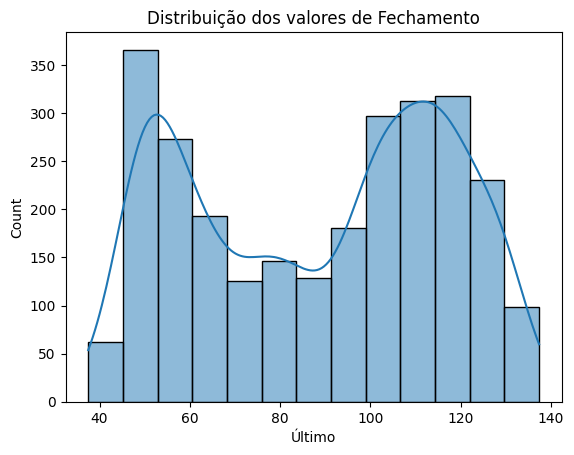

In [24]:
sns.histplot(dados_brutos['Último'], kde=True)
plt.title('Distribuição dos valores de Fechamento')
plt.show()

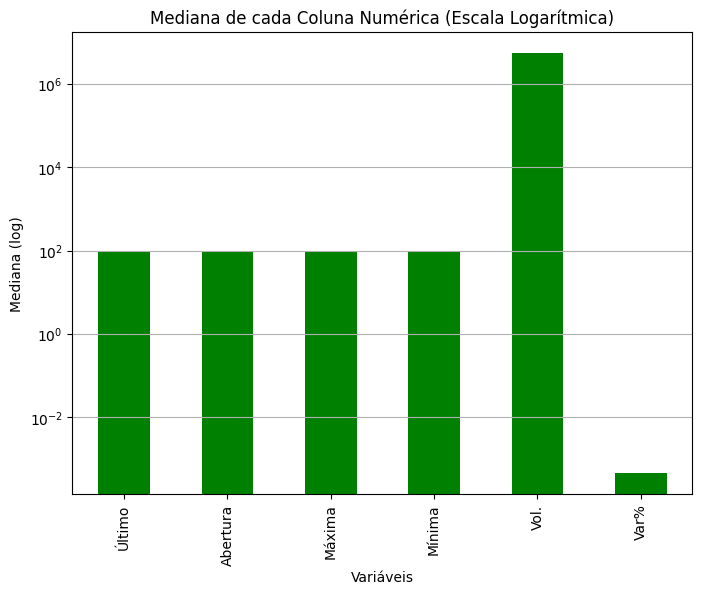

In [25]:
# Gráfico de medianas

medianas = dados_brutos[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']].median()
plt.figure(figsize=(8, 6))
medianas.plot(kind='bar', color='green')
plt.yscale('log')
plt.title('Mediana de cada Coluna Numérica (Escala Logarítmica)')
plt.xlabel('Variáveis')
plt.ylabel('Mediana (log)')
plt.grid(axis='y')
plt.show()


Desvio Padrão de cada coluna numérica:
Último      2.822262e+01
Abertura    2.822525e+01
Máxima      2.835447e+01
Mínima      2.808350e+01
Vol.        4.128395e+06
Var%        1.517954e-02
dtype: float64


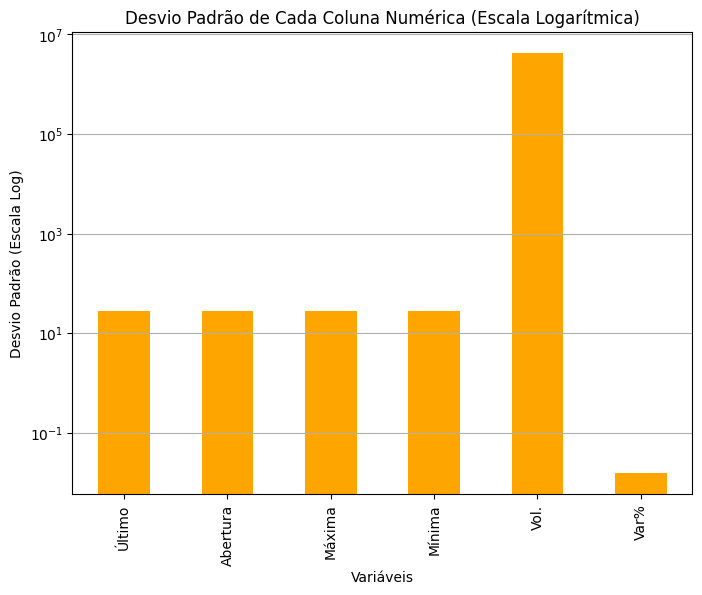

In [26]:
# Desvio Padrão
print("\nDesvio Padrão de cada coluna numérica:")
desvios = dados_brutos.std(numeric_only=True)
print(desvios)

# Gráfico de Desvio Padrão com Escala Logarítmica, visto que cada coluna possui uma escala diferente
plt.figure(figsize=(8, 6))
desvios.plot(kind='bar', color='orange', logy=True)  # Escala logarítmica no eixo Y
plt.title('Desvio Padrão de Cada Coluna Numérica (Escala Logarítmica)')
plt.xlabel('Variáveis')
plt.ylabel('Desvio Padrão (Escala Log)')
plt.grid(axis='y')
plt.show()





Boxplots para Identificação de Outliers:


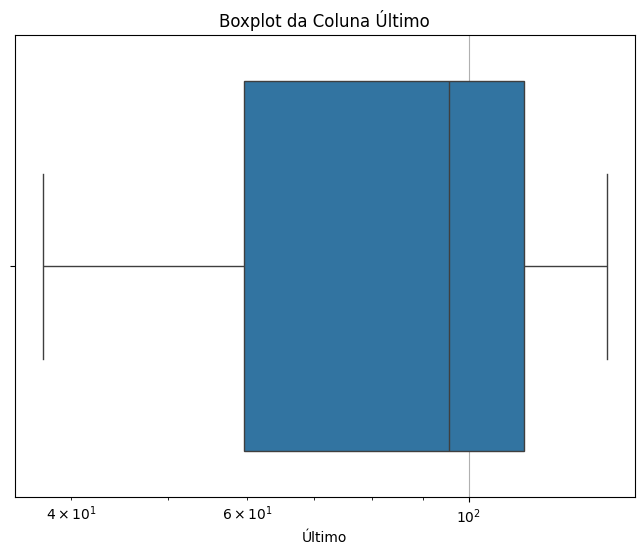

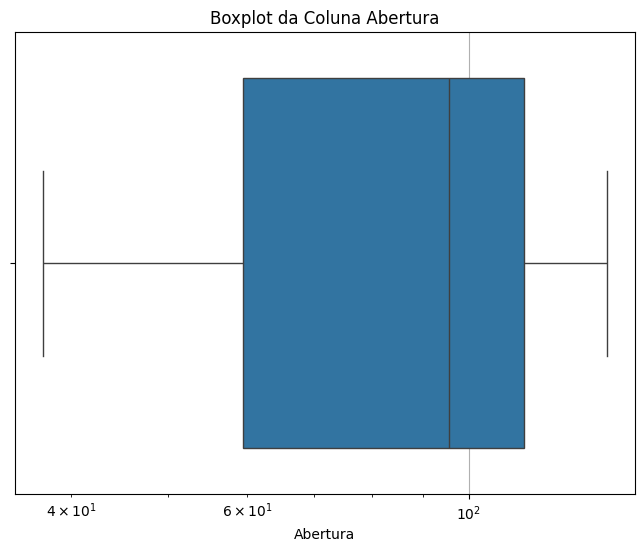

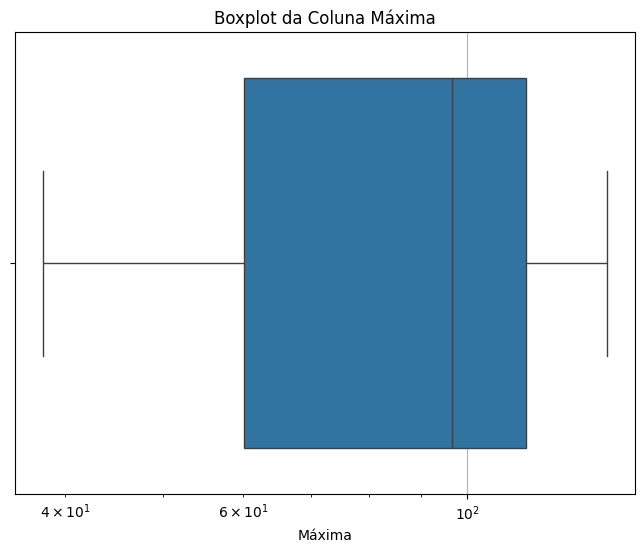

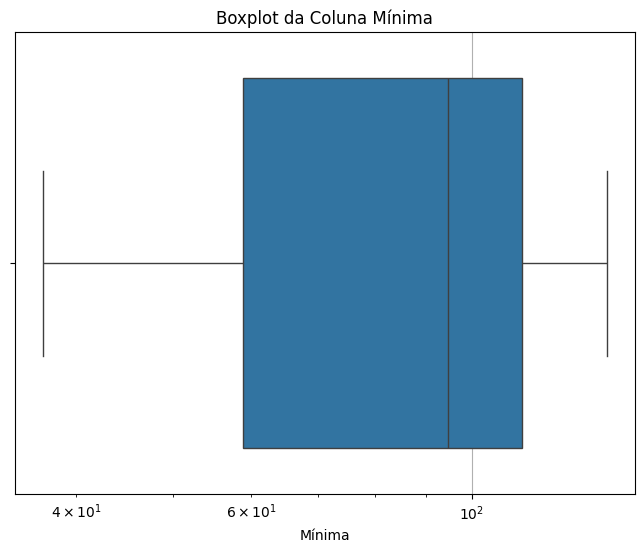

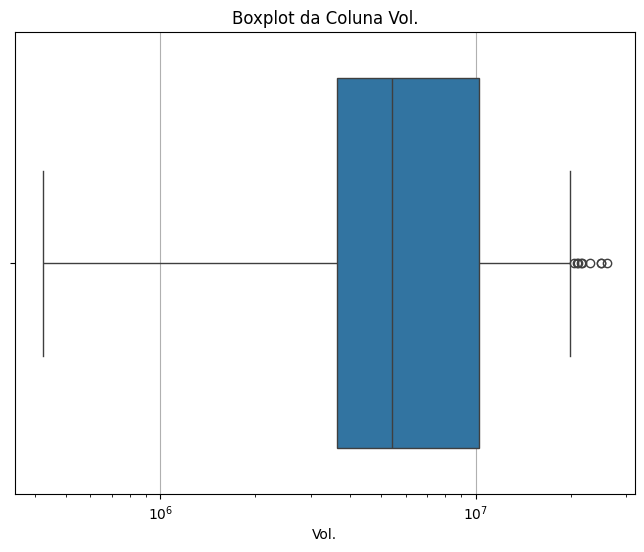

In [27]:
# Gráfico Boxplots para Outliers
print("\nBoxplots para Identificação de Outliers:")
for col in ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=dados_brutos[col])
    plt.title(f'Boxplot da Coluna {col}')
    plt.xlabel(col)
    plt.xscale('log')  # Escala logarítmica no eixo X
    plt.grid(axis='x')
    plt.show()

In [29]:
# Correlação Não Linear
print("\nCorrelação Não Linear (Spearman e Kendall):")
spearman_corr, _ = spearmanr(dados_brutos['Último'], dados_brutos['Abertura'])
kendall_corr, _ = kendalltau(dados_brutos['Último'], dados_brutos['Abertura'])
print(f"Correlação de Spearman (Último x Abertura): {spearman_corr:.4f}")
print(f"Correlação de Kendall (Último x Abertura): {kendall_corr:.4f}")


Correlação Não Linear (Spearman e Kendall):


NameError: name 'spearmanr' is not defined

In [ ]:
#Na análise acima foi possível observar que na Correlação de Spearman (0.9984):Quando o valor de Abertura aumenta, o valor de Último também tende a aumentar, e vice-versa. E na Correlação de Kendall (0.9669):Nos dias em que a abertura foi maior também correspondem a dias em que o fechamento foi maior. Esses resultados sugerem que as colunas Último e Abertura têm um comportamento altamente correlacionado, o que é esperado em dados financeiros.

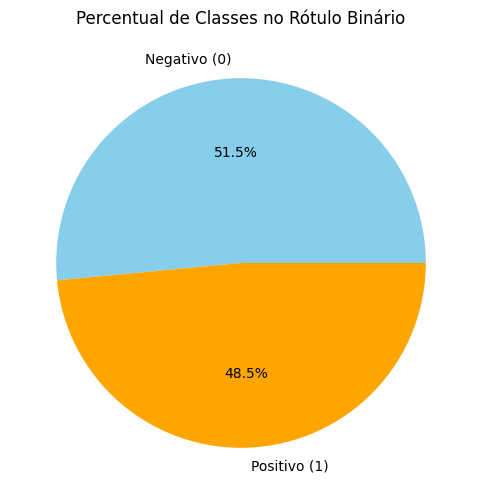

In [192]:
# Criei um rótulo binário (1 se 'Var%' > 0, senão 0) que será usada como a variável dependente (ou alvo) no modelo de classificação, para simplificar a predição usando binario.
dados_brutos['Rótulo'] = (dados_brutos['Var%'] > 0).astype(int)
distribuicao = dados_brutos['Rótulo'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(distribuicao, labels=['Negativo (0)', 'Positivo (1)'], autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title('Percentual de Classes no Rótulo Binário')
plt.show()

In [193]:
X = dados_brutos[['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']]  # Variáveis preditoras
y = dados_brutos['Rótulo']  # Rótulo binário

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#Fase de separação dos dados entre teste (30%) e treino (70%)

In [195]:
# Imputar valores ausentes com a média, pois assim preservaremos ao máximo os valores
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [196]:
# Normalização dos dados, apesar de no gráfico de outliers nao ter outliers nas colunas Abertura e Ultimo, preferi normalizar os dados de todas as colunas por causa do modelo GaussianNB que é sensível a dados muito dispersos.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [197]:
modelo = GaussianNB()
modelo.fit(X_train, y_train)
#Treinando o modelo com os dados de treino

GaussianNB()

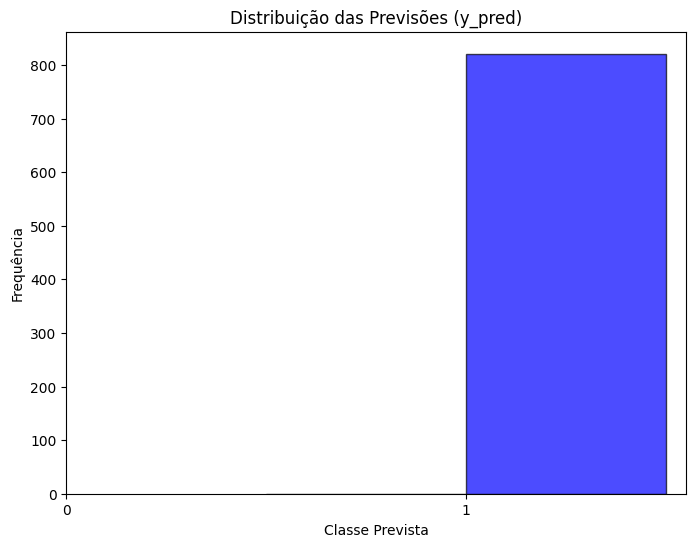

In [201]:
y_pred = modelo.predict(X_test)
#Previsões

# Distribuição das previsões
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=2, edgecolor='black', color='blue', alpha=0.7)
plt.xticks([0, 1])
plt.title('Distribuição das Previsões (y_pred)')
plt.xlabel('Classe Prevista')
plt.ylabel('Frequência')
plt.show()

Erro Médio Absoluto (MAE): 0.4848



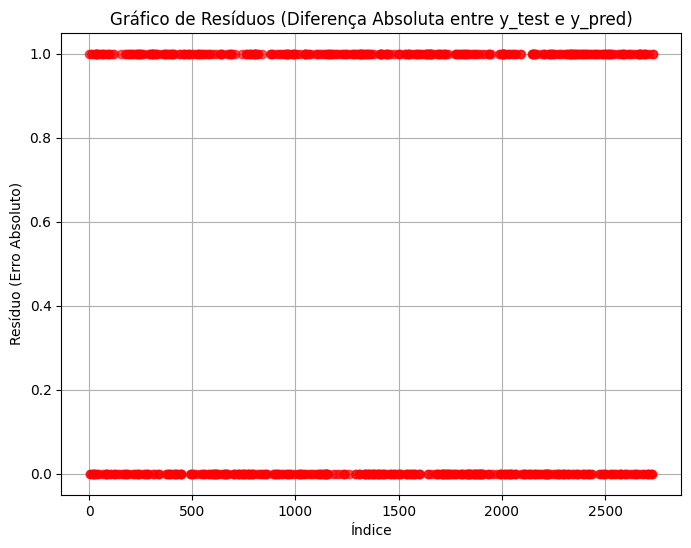

In [202]:
# MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro Médio Absoluto (MAE): {mae:.4f}\n")



# Resíduos
residuos = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))
plt.plot(residuos, marker='o', linestyle='', color='red', alpha=0.6)
plt.title('Gráfico de Resíduos (Diferença Absoluta entre y_test e y_pred)')
plt.xlabel('Índice')
plt.ylabel('Resíduo (Erro Absoluto)')
plt.grid()
plt.show()

Acurácia do modelo: 51.52%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       398
           1       0.52      1.00      0.68       423

    accuracy                           0.52       821
   macro avg       0.26      0.50      0.34       821
weighted avg       0.27      0.52      0.35       821



c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

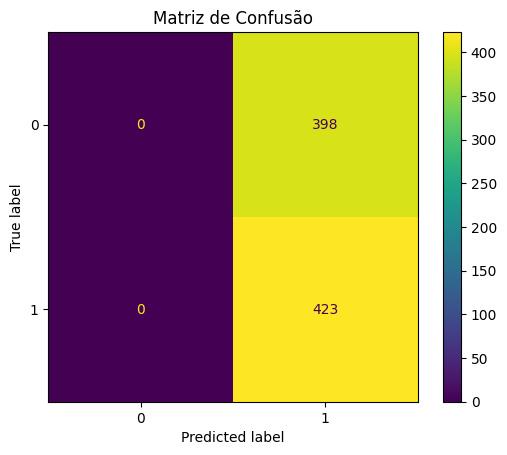

In [203]:
acuracia = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {acuracia * 100:.2f}%\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

#Matriz de Confusão: Ela mostra o desempenho do modelo ajudando a entender como o modelo acerta e onde erra.
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)
plt.title('Matriz de Confusão')
plt.show()